# Code

### `tm_squeezing(N,s)`, `tm_mixing(N, )`

In [34]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb, factorial
%matplotlib inline

def tm_squeezing(N, s):
    """ Two-mode squeezing operator
        N: a positive interger. Photon number is truncated at N, i.e (0, N-1)
        s: a complex number. 's' is the squeezing parameter.
        return: a qutip.Qobj(), operator
    """
    a = destroy(N)
    tms = - np.conj(s) * tensor(a, a) + s * tensor(a.dag(), a.dag())
    return tms.expm()


def tm_mixing(N, s):
    """ Two-mode mixing operator. Photon number is truncated at N. """
    a = destroy(N)
    tmm = s * tensor(a.dag(), a) - np.conj(s) * tensor(a, a.dag())
    return tmm.expm()

### `TMSS(N,s)`, `PS(N,s)`, `PA(N,s)`, `PSA(N,s)`, `PAS(N,s)`, and `PCS(N,s)`

In [35]:
def TMSS(N, s):
    """ Two-mode squeezed state
        N: a positive interger. Photon number is truncated at N, i.e (0, N-1)
        s: a complex number. 's' is the squeezing parameter.
        return: a qutip.Qobj(), vector state
    """
    l = np.tanh(s.real)
    state = np.sum([l**n * tensor(basis(N, n), basis(N, n)) \
                    for n in xrange(N)])
    return state.unit()


def PS(N, s):
    """ Photon subtracted two-mode squeezed state
        N: a positive interger. Photon number is truncated at N, i.e (0, N-1)
        s: a complex number. 's' is the squeezing parameter.
        return: a qutip.Qobj(), vector state
    """
    l = np.tanh(s.real)
    state = np.sum([(n+1) * l**n * tensor(basis(N, n), basis(N, n)) \
                    for n in xrange(N)])
    return state.unit()


def PA(N, s):
    """ Photon added two-mode squeezed state
        N: a positive interger. Photon number is truncated at N, i.e (0, N-1)
        s: a complex number. 's' is the squeezing parameter.
        return: a qutip.Qobj(), vector state
    """
    l = np.tanh(s.real)
    state = np.sum([(n+1) * l**n * tensor(basis(N, n + 1), basis(N, n + 1)) \
                    for n in xrange(N - 1)])
    return state.unit()    


def PSA(N, s):
    """ Photon added then subtracted two-mode squeezed state
        N: a positive interger. Photon number is truncated at N, i.e (0, N-1)
        s: a complex number. 's' is the squeezing parameter.
        return: a qutip.Qobj(), vector state
    """
    l = np.tanh(s.real)
    state = np.sum([(n+1)**2 * l**n * tensor(basis(N, n), basis(N, n)) \
                    for n in xrange(N)])
    return state.unit()


def PAS(N, s):
    """ Photon subtracted then added two-mode squeezed state
        N: a positive interger. Photon number is truncated at N, i.e (0, N-1)
        s: a complex number. 's' is the squeezing parameter.
        return: a qutip.Qobj(), vector state
    """
    l = np.tanh(s.real)
    state = np.sum([(n+1)**2 * l**n * tensor(basis(N, n + 1), basis(N, n + 1)) \
                    for n in xrange(N - 1)])
    return state.unit()


def PCS(N, s, rt_list):
    """ Coherent superposition of photon subtraction and addition on two-mode squeezed state
        N: a positive interger. Photon number is truncated at N, i.e (0, N-1)
        s: a complex number. 's' is the squeezing parameter.
        r: complex numbers.
        return: a qutip.Qobj(), vector state
    """
    l = np.tanh(s.real)
    ra, ta, rb, tb = rt_list
    
    nlist = range(N)
    state1 = np.sum([l**(n+1) * (n+1) * tensor(basis(N, n), basis(N, n)) \
                    for n in nlist])
    state2 = np.sum([l**(n+1) * np.sqrt((n+1)*(n+2)) \
                    * tensor(basis(N, n), basis(N, n + 2)) for n in nlist[:-2]])
    state3 = np.sum([l**(n+1) * np.sqrt((n+1)*(n+2)) \
                    * tensor(basis(N, n + 2), basis(N, n)) for n in nlist[:-2]])
    state4 = np.sum([l**n * (n+1) * tensor(basis(N, n + 1), basis(N, n + 1)) \
                    for n in nlist[:-1]])
    state = ta * tb * state1 + ta * rb * state2 + ra * tb * state3 + ra * rb * state4
    
    return state.unit()

### `RHO_0(state,N,s,Nth,rt_list)`, `RHO_1(state,N,s,Nth,eta,rt_list)`

In [36]:
def RHO_0(state, N, s, Nth, rt_list=False):
    """ State obtained if the object is absent.
        N: a positive interger. Photon number is truncated at N, i.e (0, N-1)
        s: a complex number. 's' is the squeezing parameter.
        r: complex numbers.
        return: a qutip.Qobj(), density matrix
    """
    if not rt_list:
        rho_AB = ket2dm(state(N, s))
    else:
        rho_AB = ket2dm(state(N, s, rt_list))
    return tensor(rho_AB.ptrace(0), thermal_dm(N, Nth)) # state A kept, state B traced out


def RHO_1(state, N, s, Nth, eta, rt_list=False):
    """ State obtained if the object is present.
        N: a positive interger. Photon number is truncated at N, i.e (0, N-1)
        s: a complex number. 's' is the squeezing parameter.
        r: complex numbers.
        return: a qutip.Qobj(), density matrix
    """
    theta = np.arctan(np.sqrt((1 - eta)/eta))
    if not rt_list:
        rho_AB = ket2dm(state(N, s))
    else:
        rho_AB = ket2dm(state(N, s, rt_list))
    
    # tensor product of state AB and thermal state
    rho = tensor(rho_AB, thermal_dm(N, Nth/(1-eta)))
    
    # state A unchanged, tm_mixing acted on state B and thermal
    op = tensor(qeye(N), tm_mixing(N, -theta))

    rho_1 = op * rho * op.dag()
    return rho_1.ptrace([0, 1])

### `QCB(rho_0, rho_1, approx=False)`

In [37]:
def QCB(rho_0, rho_1, approx=False):
    """ Approximated Q for QCB
        Actually the trace of sqrt(rho_1) * sqrt(rho_2)
    """
    if approx:
        return (rho_0.sqrtm() * rho_1.sqrtm()).tr().real
    else:
        pass

### `upper_bound(QCB, M)`, `lower_bound(tr, M)`

In [38]:
def upper_bound(QCB, M):
    """ Upper bound (Quantum Chernoff bound) of the error probability
        using s = 1/2
    """
    return 0.5 * QCB ** M


def lower_bound(tr, M):
    """ Lower bound of the error probability
    """
    return (1 - np.sqrt(1 - tr ** (2 * M))) / 2

In [39]:
np.set_printoptions(threshold='nan', precision=6, suppress=True)

# I. Quantum Illumination with Non-Gaussian States

## Evaluating

In [41]:
# Evaluating states
def P_ERR_vs_M_Data(Nth, N, kappa, s):
    # TMSS
    rho_0_tmss = RHO_0(TMSS, N, s, Nth)
    rho_1_tmss = RHO_1(TMSS, N, s, Nth, kappa)
    tr_tmss = QCB(rho_0_tmss, rho_1_tmss, approx=True)
    
    # Photon subtraction
    rho_0_ps = RHO_0(PS, N, s, Nth)
    rho_1_ps = RHO_1(PS, N, s, Nth, kappa)
    tr_ps = QCB(rho_0_ps, rho_1_ps, approx=True)
    
    # Photon addition then subtranction
    rho_0_psa = RHO_0(PSA, N, s, Nth)
    rho_1_psa = RHO_1(PSA, N, s, Nth, kappa)
    tr_psa = QCB(rho_0_psa, rho_1_psa, approx=True)
    
    # Coherent superposition of photon subtraction and addition
    rt_list = (0.4, np.sqrt(0.86), 0.4, np.sqrt(0.86))
    rho_0_pcs = RHO_0(PCS, N, s, Nth, rt_list)
    rho_1_pcs = RHO_1(PCS, N, s, Nth, kappa, rt_list)
    tr_pcs = QCB(rho_0_pcs, rho_1_pcs, approx=True)
    
    # Tr[rho_0**0.5 * rho_1**0.5]
    print tr_tmss, tr_ps, tr_psa, tr_pcs
    
    # Number of identity copied M: form 1e2 to 1e6, log space
    x = np.logspace(2, 6, num=50)
    x = np.array([np.int(i) for i in x])
    
    # Caculate upper bounds and lower bounds
    dataL_tmss = np.array([lower_bound(tr_tmss, M) for M in x])
    dataU_tmss = np.array([upper_bound(tr_tmss, M) for M in x])
    dataL_ps = np.array([lower_bound(tr_ps, M) for M in x])
    dataU_ps = np.array([upper_bound(tr_ps, M) for M in x])
    dataL_psa = np.array([lower_bound(tr_psa, M) for M in x])
    dataU_psa = np.array([upper_bound(tr_psa, M) for M in x])
    dataL_pcs = np.array([lower_bound(tr_pcs, M) for M in x])
    dataU_pcs = np.array([upper_bound(tr_pcs, M) for M in x])
    
    return x, dataL_tmss, dataU_tmss, dataL_ps, dataU_ps, \
            dataL_psa, dataU_psa, dataL_pcs, dataU_pcs

## Ploting

In [42]:
def P_ERR_vs_M_Plot(title, data):
    x, dataL_tmss, dataU_tmss, dataL_ps, dataU_ps, \
            dataL_psa, dataU_psa, dataL_pcs, dataU_pcs = data
    
    fig, ax = plt.subplots()
    
    ax.plot(x, dataL_tmss, color='b', label='TMSS')
    ax.plot(x, dataU_tmss, color='r', label='TMSS')
    ax.plot(x, dataL_ps, color='b', ls='--', label='PS')
    ax.plot(x, dataU_ps, color='r', ls='--', label='PS')
    ax.plot(x, dataL_psa, color='b', ls='-.', label='PSA')
    ax.plot(x, dataU_psa, color='r', ls='-.', label='PSA')
    ax.plot(x, dataL_pcs, color='b', ls=':', label='PCS')
    ax.plot(x, dataU_pcs, color='r', ls=':', label='PCS')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e-6, 1])
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('$M$', fontsize=16)
    ax.set_ylabel('$P_{err}$', fontsize=16)

    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=None)
    
    return fig, lgd

### 1. $N_s = 0.01, N_{th} = 0.1, \eta = 0.01$.

0.999914200049 0.999677113284 0.998900522122 0.996510178093


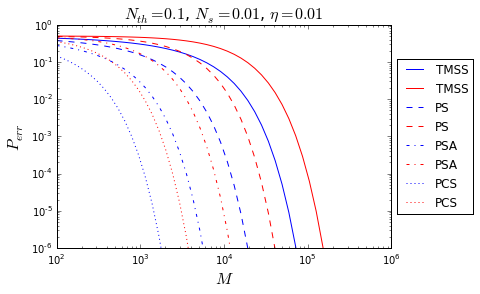

In [43]:
Nth = 0.1     # Average thermal photon numbers
N = 10        # Truncated photon numbers, i.e., 0 ~ N-1
eta = 0.01    # Transmissivity

Ns = 0.01     # Average photon number of the initial two-mode squeezed states
lmd = np.sqrt(Ns/(1 + Ns))     # 
s = np.arcsinh(np.sqrt(Ns))    # Squeezed parameter

data = P_ERR_vs_M_Data(Nth, N, eta, s)
fig, lgd = P_ERR_vs_M_Plot('$N_{th} = 0.1$, $N_s = 0.01$, $\eta = 0.01$', data)
fig.savefig("N_1e-1.svg", bbox_extra_artists=(lgd,), bbox_inches='tight')

### 2. $N_s = 0.01, N_{th} = 1, \eta = 0.01$.

0.999956151234 0.999845864667 0.99953052365 0.998938178672


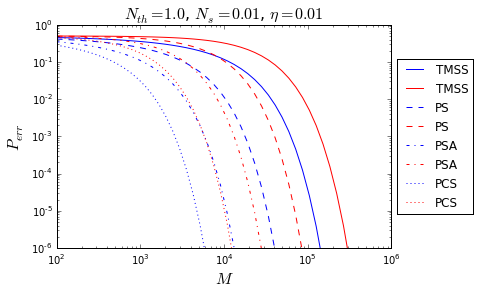

In [30]:
Nth = 1       # Average thermal photon numbers
N = 15        # Truncated photon numbers, i.e., 0 ~ N-1
eta = 0.01    # Transmissivity

Ns = 0.01     # Average photon number of the initial two-mode squeezed states
lmd = np.sqrt(Ns/(1 + Ns))     # 
s = np.arcsinh(np.sqrt(Ns))    # Squeezed parameter

data = P_ERR_vs_M_Data(Nth, N, eta, s)
fig, lgd = P_ERR_vs_M_Plot('$N_{th} = 1.0$, $N_s = 0.01$, $\eta = 0.01$', data)
fig.savefig("N_1e0.svg", bbox_extra_artists=(lgd,), bbox_inches='tight')

### 3. $N_s = 0.01, N_{th} = 10, \eta = 0.01$.

0.999830445726 0.999546584701 0.998631285016 0.99632083879


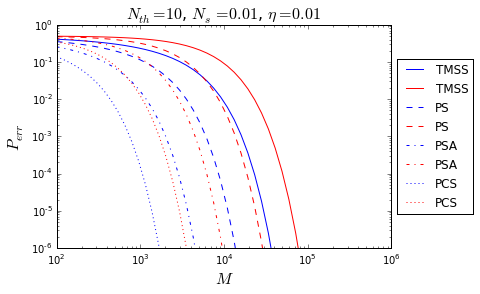

In [31]:
Nth = 10      # Average thermal photon numbers
N = 20        # Truncated photon numbers, i.e., 0 ~ N-1
eta = 0.01    # Transmissivity

Ns = 0.01     # Average photon number of the initial two-mode squeezed states
lmd = np.sqrt(Ns/(1 + Ns))     # 
s = np.arcsinh(np.sqrt(Ns))    # Squeezed parameter

data = P_ERR_vs_M_Data(Nth, N, eta, s)
fig, lgd = P_ERR_vs_M_Plot('$N_{th} = 10$, $N_s = 0.01$, $\eta = 0.01$', data)
fig.savefig("N_1e1.svg", bbox_extra_artists=(lgd,), bbox_inches='tight')

## P_ERR vs Ns

In [3]:
def P_ERR_vs_Ns_Data(Nth, N, kappa, M=10):
    Ns = np.logspace(-2, 0, 20)
    s_list = np.arcsinh(np.sqrt(Ns))
    
    # TMSS
    rho_list = np.array([(RHO_0(TMSS, N, s, Nth), RHO_1(TMSS, N, s, Nth, kappa)) \
                          for s in s_list])
    tr_tmss = np.array([(rho[0].sqrtm() * rho[1].sqrtm()).tr().real 
                        for rho in rho_list])
    
    # PSTMSS
    rho_list = np.array([(RHO_0(PSTMSS, N, s, Nth), RHO_1(PSTMSS, N, s, Nth, kappa)) \
                          for s in s_list])
    tr_ps = np.array([(rho[0].sqrtm() * rho[1].sqrtm()).tr().real 
                        for rho in rho_list])
    
    # PSATMSS
    rho_list = np.array([(RHO_0(PSATMSS, N, s, Nth), RHO_1(PSATMSS, N, s, Nth, kappa)) \
                          for s in s_list])
    tr_psa = np.array([(rho[0].sqrtm() * rho[1].sqrtm()).tr().real 
                        for rho in rho_list])
    
    # PCSSATMSS
    rho_list = np.array([(RHO_0(PCSSATMSS, N, s, Nth, r=0.4), \
                          RHO_1(PCSSATMSS, N, s, Nth, kappa, r=0.4)) \
                          for s in s_list])
    tr_pcssa = np.array([(rho[0].sqrtm() * rho[1].sqrtm()).tr().real 
                        for rho in rho_list])
    
    return Ns, tr_tmss, tr_ps, tr_psa, tr_pcssa

In [4]:
def P_ERR_vs_Ns_Plot(title, data):
    x, dataL_tmss, dataU_tmss, dataL_ps, dataU_ps, \
            dataL_psa, dataU_psa, dataL_pcssa, dataU_pcssa = data

    fig, ax = plt.subplots()
    
    ax.plot(x, dataL_tmss, color='b', label=r'$\left|TMSS\right\rangle$')
    ax.plot(x, dataU_tmss, color='r', label=r'$\left|TMSS\right\rangle$')
    ax.plot(x, dataL_ps, color='b', ls='--', label=r'$\hat{a}\hat{b}\left|TMSS\right\rangle$')
    ax.plot(x, dataU_ps, color='r', ls='--', label=r'$\hat{a}\hat{b}\left|TMSS\right\rangle$')
    ax.plot(x, dataL_psa, color='b', ls='-.', \
            label=r'$\hat{a}\hat{a}^\dagger\hat{b}\hat{b}^\dagger\left|TMSS\right\rangle$')
    ax.plot(x, dataU_psa, color='r', ls='-.', \
            label=r'$\hat{a}\hat{a}^\dagger\hat{b}\hat{b}^\dagger\left|TMSS\right\rangle$')
    ax.plot(x, dataL_pcssa, color='b', ls=':', \
            label=r'$(t\hat{a}+r\hat{a}^\dagger)(t\hat{b}+r\hat{b}^\dagger)\left|TMSS\right\rangle$')
    ax.plot(x, dataU_pcssa, color='r', ls=':', \
            label=r'$(t\hat{a}+r\hat{a}^\dagger)(t\hat{b}+r\hat{b}^\dagger)\left|TMSS\right\rangle$')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
#     ax.set_ylim([1e-6, 1])
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('$N_s$', fontsize=16)
    ax.set_ylabel('$P_{err}$', fontsize=16)

    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=None)
    
    return fig, lgd

In [5]:
# Setting parameters
Nth = 10
N = 20
kappa = 0.01
# N_s (0.01, ..., 0.1)
data_Nth_10 = P_ERR_vs_Ns_Data(Nth, N, kappa)

In [12]:
data_Nth_10

(array([ 0.01    ,  0.012743,  0.016238,  0.020691,  0.026367,  0.033598,
         0.042813,  0.054556,  0.069519,  0.088587,  0.112884,  0.143845,
         0.183298,  0.233572,  0.297635,  0.379269,  0.483293,  0.615848,
         0.78476 ,  1.      ]),
 array([ 0.99983 ,  0.999803,  0.999769,  0.999725,  0.999671,  0.999603,
         0.999518,  0.999412,  0.999279,  0.999115,  0.99891 ,  0.998656,
         0.998342,  0.997953,  0.997472,  0.996877,  0.99614 ,  0.995227,
         0.994086,  0.992649]),
 array([ 0.999547,  0.999448,  0.999326,  0.999175,  0.998989,  0.998759,
         0.998477,  0.998131,  0.997708,  0.997193,  0.996564,  0.995799,
         0.994867,  0.993733,  0.992348,  0.990652,  0.988555,  0.985924,
         0.982539,  0.978014]),
 array([ 0.998631,  0.998342,  0.997998,  0.997592,  0.997117,  0.996563,
         0.99592 ,  0.995175,  0.994314,  0.993315,  0.992156,  0.990803,
         0.989215,  0.987332,  0.985066,  0.982279,  0.978759,  0.974147,
         0.96776

In [11]:
np.savetxt("data_Nth_10_Ns.cvs", data_Nth_10)

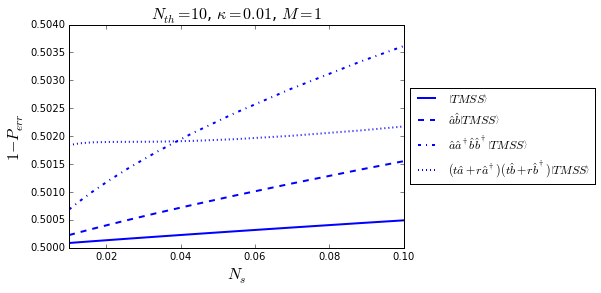

In [24]:
Ns, tr_tmss, tr_ps, tr_psa, tr_pcssa = data_Nth_10
fig, ax = plt.subplots()
ax.set_xlim([0.01, 0.1])
ax.set_ylim([0.5, 0.504])
ax.plot(Ns, 1 - tr_tmss**1/2, color='b', lw=2, label=r'$\left|TMSS\right\rangle$')
ax.plot(Ns, 1 - tr_ps**1/2, color='b', ls='--', lw=2, label=r'$\hat{a}\hat{b}\left|TMSS\right\rangle$')
ax.plot(Ns, 1 - tr_psa**1/2, color='b', ls='-.', lw=2, \
        label=r'$\hat{a}\hat{a}^\dagger\hat{b}\hat{b}^\dagger\left|TMSS\right\rangle$')
ax.plot(Ns, 1 - tr_pcssa**1/2, color='b', ls=':', lw=2, \
        label=r'$(t\hat{a}+r\hat{a}^\dagger)(t\hat{b}+r\hat{b}^\dagger)\left|TMSS\right\rangle$')

# ax.plot(Ns, (1 + np.sqrt(1 - tr_tmss**200))/2, color='r', \
#         label=r'$\left|TMSS\right\rangle$')
# ax.plot(Ns, (1 + np.sqrt(1 - tr_ps**200))/2, color='r', ls='--', \
#         label=r'$\hat{a}\hat{b}\left|TMSS\right\rangle$')
# ax.plot(Ns, (1 + np.sqrt(1 - tr_psa**200))/2, color='r', ls='-.', \
#         label=r'$\hat{a}\hat{a}^\dagger\hat{b}\hat{r}^\dagger\left|TMSS\right\rangle$')
# ax.plot(Ns, (1 + np.sqrt(1 - tr_pcssa**200))/2, color='r', ls=':', \
#         label=r'$(t\hat{a}+r\hat{a}^\dagger)(t\hat{b}+r\hat{b}^\dagger)\left|TMSS\right\rangle$')

ax.set_title('$N_{th}=10$, $\kappa=0.01$, $M=1$', fontsize=16)
ax.set_xlabel('$N_s$', fontsize=16)
ax.set_ylabel('$1 - P_{err}$', fontsize=16)
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=None)
fig.savefig("Nth_1e1_ERR_vs_Ns.svg", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [14]:
# Setting parameters
Nth = 1
N = 15
kappa = 0.01
# N_s (0.01, ..., 0.1)
data_Nth_1 = P_ERR_vs_Ns_Data(Nth, N, kappa)

In [25]:
data_Nth_1

(array([ 0.01    ,  0.012743,  0.016238,  0.020691,  0.026367,  0.033598,
         0.042813,  0.054556,  0.069519,  0.088587,  0.112884,  0.143845,
         0.183298,  0.233572,  0.297635,  0.379269,  0.483293,  0.615848,
         0.78476 ,  1.      ]),
 array([ 0.999956,  0.999945,  0.999931,  0.999914,  0.999893,  0.999867,
         0.999835,  0.999797,  0.999749,  0.999692,  0.999622,  0.999537,
         0.999435,  0.999312,  0.999163,  0.998982,  0.99876 ,  0.998486,
         0.998138,  0.997678]),
 array([ 0.999846,  0.99981 ,  0.999766,  0.999712,  0.999648,  0.999571,
         0.999479,  0.999369,  0.999237,  0.99908 ,  0.998892,  0.998666,
         0.998393,  0.99806 ,  0.99765 ,  0.997138,  0.996481,  0.995589,
         0.994245,  0.991991]),
 array([ 0.999531,  0.999438,  0.999331,  0.999208,  0.999067,  0.998905,
         0.99872 ,  0.998506,  0.998258,  0.997968,  0.997626,  0.997217,
         0.996724,  0.996122,  0.995368,  0.994375,  0.992923,  0.990486,
         0.98601

In [27]:
np.savetxt("data_Nth_1.csv", data_Nth_1)

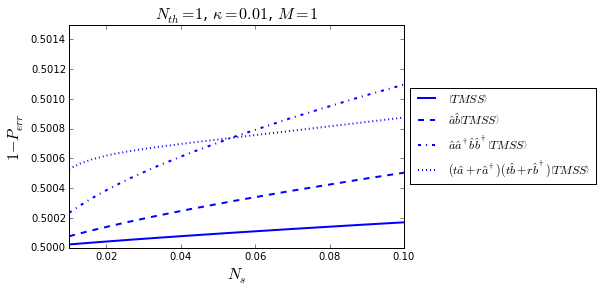

In [23]:
Ns, tr_tmss, tr_ps, tr_psa, tr_pcssa = data_Nth_1
fig, ax = plt.subplots()
ax.set_xlim([0.01, 0.1])
ax.set_ylim([0.5, 0.5015])
ax.plot(Ns, 1 - tr_tmss**1/2, color='b', lw=2, label=r'$\left|TMSS\right\rangle$')
ax.plot(Ns, 1 - tr_ps**1/2, color='b', ls='--', lw=2, label=r'$\hat{a}\hat{b}\left|TMSS\right\rangle$')
ax.plot(Ns, 1 - tr_psa**1/2, color='b', ls='-.', lw=2, \
        label=r'$\hat{a}\hat{a}^\dagger\hat{b}\hat{b}^\dagger\left|TMSS\right\rangle$')
ax.plot(Ns, 1 - tr_pcssa**1/2, color='b', ls=':', lw=2, \
        label=r'$(t\hat{a}+r\hat{a}^\dagger)(t\hat{b}+r\hat{b}^\dagger)\left|TMSS\right\rangle$')
# ax.plot(Ns, (1 + np.sqrt(1 - tr_tmss**200))/2, color='r', label=r'$\left|TMSS\right\rangle$')
# ax.plot(Ns, (1 + np.sqrt(1 - tr_ps**200))/2, color='r', ls='--', label=r'$\hat{a}\hat{b}\left|TMSS\right\rangle$')
# ax.plot(Ns, (1 + np.sqrt(1 - tr_psa**200))/2, color='r', ls='-.', \
#         label=r'$\hat{a}\hat{a}^\dagger\hat{b}\hat{r}^\dagger\left|TMSS\right\rangle$')
# ax.plot(Ns, (1 + np.sqrt(1 - tr_pcssa**200))/2, color='r', ls=':', \
#         label=r'$(t\hat{a}+r\hat{a}^\dagger)(t\hat{b}+r\hat{b}^\dagger)\left|TMSS\right\rangle$')
ax.set_title('$N_{th}=1$, $\kappa=0.01$, $M=1$', fontsize=16)
ax.set_xlabel('$N_s$', fontsize=16)
ax.set_ylabel('$1 - P_{err}$', fontsize=16)
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=None)
fig.savefig("N_1e0_ERR_vs_Ns.svg", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [26]:
# Setting parameters
Nth = 0.1
N = 10
kappa = 0.01
# N_s (0.01, ..., 0.1)
data_Nth_01 = P_ERR_vs_Ns_Data(Nth, N, kappa)

In [30]:
data_Nth_01

(array([ 0.01    ,  0.012743,  0.016238,  0.020691,  0.026367,  0.033598,
         0.042813,  0.054556,  0.069519,  0.088587,  0.112884,  0.143845,
         0.183298,  0.233572,  0.297635,  0.379269,  0.483293,  0.615848,
         0.78476 ,  1.      ]),
 array([ 0.999914,  0.999891,  0.999863,  0.999827,  0.999782,  0.999725,
         0.999654,  0.999565,  0.999454,  0.999316,  0.999145,  0.998932,
         0.998667,  0.99834 ,  0.997933,  0.997429,  0.996801,  0.996017,
         0.995031,  0.993789]),
 array([ 0.999677,  0.999595,  0.999492,  0.999365,  0.999208,  0.999014,
         0.998775,  0.998481,  0.998122,  0.997682,  0.997144,  0.996487,
         0.995683,  0.994695,  0.993477,  0.991961,  0.990052,  0.987621,
         0.984531,  0.980712]),
 array([ 0.998901,  0.998653,  0.998358,  0.998009,  0.997599,  0.99712 ,
         0.996563,  0.995917,  0.995164,  0.994286,  0.993254,  0.992032,
         0.990568,  0.988793,  0.986596,  0.983815,  0.98024 ,  0.975716,
         0.97029

In [31]:
np.savetxt("data_Nth_01.csv", data_Nth_01)

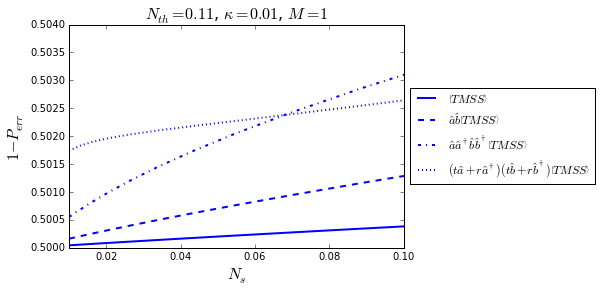

In [29]:
Ns, tr_tmss, tr_ps, tr_psa, tr_pcssa = data_Nth_01
fig, ax = plt.subplots()
ax.set_xlim([0.01, 0.1])
ax.set_ylim([0.5, 0.504])
ax.plot(Ns, 1 - tr_tmss**1/2, color='b', lw=2, label=r'$\left|TMSS\right\rangle$')
ax.plot(Ns, 1 - tr_ps**1/2, color='b', ls='--', lw=2, label=r'$\hat{a}\hat{b}\left|TMSS\right\rangle$')
ax.plot(Ns, 1 - tr_psa**1/2, color='b', ls='-.', lw=2, \
        label=r'$\hat{a}\hat{a}^\dagger\hat{b}\hat{b}^\dagger\left|TMSS\right\rangle$')
ax.plot(Ns, 1 - tr_pcssa**1/2, color='b', ls=':', lw=2, \
        label=r'$(t\hat{a}+r\hat{a}^\dagger)(t\hat{b}+r\hat{b}^\dagger)\left|TMSS\right\rangle$')
# ax.plot(Ns, (1 + np.sqrt(1 - tr_tmss**200))/2, color='r', label=r'$\left|TMSS\right\rangle$')
# ax.plot(Ns, (1 + np.sqrt(1 - tr_ps**200))/2, color='r', ls='--', label=r'$\hat{a}\hat{b}\left|TMSS\right\rangle$')
# ax.plot(Ns, (1 + np.sqrt(1 - tr_psa**200))/2, color='r', ls='-.', \
#         label=r'$\hat{a}\hat{a}^\dagger\hat{b}\hat{r}^\dagger\left|TMSS\right\rangle$')
# ax.plot(Ns, (1 + np.sqrt(1 - tr_pcssa**200))/2, color='r', ls=':', \
#         label=r'$(t\hat{a}+r\hat{a}^\dagger)(t\hat{b}+r\hat{b}^\dagger)\left|TMSS\right\rangle$')
ax.set_title('$N_{th}=0.11$, $\kappa=0.01$, $M=1$', fontsize=16)
ax.set_xlabel('$N_s$', fontsize=16)
ax.set_ylabel('$1 - P_{err}$', fontsize=16)
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=None)
fig.savefig("Nth_1e-1_ERR_vs_Ns.svg", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [23]:
for N in xrange(20, 100, 5):
    th = thermal_dm(N, 3)
    print N, th.full()[-1,-1]

20 (0.00106043350571+0j)
25 (0.000251036735441+0j)
30 (5.95379958097e-05+0j)
35 (1.41267210343e-05+0j)
40 (3.35222876585e-06+0j)
45 (7.95493498125e-07+0j)
50 (1.88773992382e-07+0j)
55 (4.47969339213e-08+0j)
60 (1.06305213155e-08+0j)
65 (2.52267247738e-09+0j)
70 (5.98642000454e-10+0j)
75 (1.42060552648e-10+0j)
80 (3.37116350412e-11+0j)
85 (7.99992901794e-12+0j)
90 (1.89842065559e-12+0j)
95 (4.50504120416e-13+0j)


In [21]:
for N in xrange(10, 50, 5):
    th = thermal_dm(N, 1)
    print N, th.full()[-1,-1]

10 (0.000977517106549+0j)
15 (3.0518509476e-05+0j)
20 (9.53675225902e-07+0j)
25 (2.98023232759e-08+0j)
30 (9.31322575483e-10+0j)
35 (2.91038304576e-11+0j)
40 (9.09494701774e-13+0j)
45 (2.84217094304e-14+0j)


In [20]:
for N in xrange(10, 20, 5):
    th = thermal_dm(N, 0.1)
    print N, th.full()[-1,-1]

10 (3.85543289444e-10+0j)
15 (2.39392049369e-15+0j)


### Test RHO_1(state, N, s, Nth, kappa, r=False)

In [33]:
state = PSTMSS
N = 5
s = 0.1
Nth = 10
kappa = 0.05
rho_1 = RHO_1(state, N, s, Nth, kappa)

In [35]:
rho_1[rho_1.full() > 1e-6]

matrix([[ 0.241424+0.j,  0.001011+0.j,  0.000012+0.j,  0.000014+0.j,
          0.218427+0.j,  0.001692+0.j,  0.000101+0.j,  0.197455+0.j,
          0.000947+0.j,  0.175437+0.j,  0.020272+0.j,  0.128204+0.j,
          0.009547+0.j,  0.000055+0.j,  0.000003+0.j,  0.001011+0.j,
          0.008927+0.j,  0.001692+0.j,  0.008344+0.j,  0.000637+0.j,
          0.000947+0.j,  0.008350+0.j,  0.000605+0.j,  0.020272+0.j,
          0.003015+0.j,  0.000212+0.j,  0.000055+0.j,  0.000205+0.j,
          0.000014+0.j,  0.000012+0.j,  0.000300+0.j,  0.000033+0.j,
          0.000005+0.j,  0.000637+0.j,  0.000051+0.j,  0.000605+0.j,
          0.000085+0.j,  0.000004+0.j,  0.000004+0.j,  0.000014+0.j,
          0.000014+0.j,  0.000033+0.j,  0.000004+0.j,  0.000101+0.j,
          0.000002+0.j,  0.000003+0.j,  0.000005+0.j]])

In [37]:
rho_1.tr(), rho_1.norm()

(0.9999999999996492, 0.99999999999964917)

### Test RHO_0(state, N, s, Nth, r=False)

In [3]:
state = PSTMSS
N = 5
s = 0.1
Nth = 10
rho_0 = RHO_0(state, N, s, Nth)

In [4]:
rho_0[rho_0.full() > 1e-6]

matrix([[ 0.230451+0.j,  0.209501+0.j,  0.190455+0.j,  0.173141+0.j,
          0.157401+0.j,  0.009157+0.j,  0.008324+0.j,  0.007568+0.j,
          0.006880+0.j,  0.006254+0.j,  0.000205+0.j,  0.000186+0.j,
          0.000169+0.j,  0.000154+0.j,  0.000140+0.j,  0.000004+0.j,
          0.000003+0.j,  0.000003+0.j,  0.000003+0.j,  0.000002+0.j]])

In [5]:
rho_0.norm()

0.99999999999999978

In [6]:
N = 5
s = 0.1
Nth = 10
l = np.tanh(s.real)
diag = [l**(2*n) * (n+1)**2 for n in xrange(5)]
rho = np.zeros((5, 5))
for i in xrange(5):
    rho[i, i] = diag[i]
rho = Qobj(rho).unit()
rho_0_t = tensor(rho, thermal_dm(N, Nth))

In [7]:
rho_0_t[rho_0_t.full() > 1e-6]

matrix([[ 0.230451+0.j,  0.209501+0.j,  0.190455+0.j,  0.173141+0.j,
          0.157401+0.j,  0.009157+0.j,  0.008324+0.j,  0.007568+0.j,
          0.006880+0.j,  0.006254+0.j,  0.000205+0.j,  0.000186+0.j,
          0.000169+0.j,  0.000154+0.j,  0.000140+0.j,  0.000004+0.j,
          0.000003+0.j,  0.000003+0.j,  0.000003+0.j,  0.000002+0.j]])

In [15]:
rho_0.tr(), rho_0_t.tr()

(0.9999999999999998, 0.9999999999999998)

In [24]:
state = PCSSATMSS
N = 5
s = 0.1
r = 0.3
Nth = 10
rho_0 = RHO_0(state, N, s, Nth, r)

In [28]:
rho_0[rho_0.full() > 1e-6]

matrix([[ 0.099720+0.j,  0.045454+0.j,  0.000401+0.j,  0.090655+0.j,
          0.041322+0.j,  0.000364+0.j,  0.082413+0.j,  0.037565+0.j,
          0.000331+0.j,  0.074921+0.j,  0.034150+0.j,  0.000301+0.j,
          0.068110+0.j,  0.031046+0.j,  0.000274+0.j,  0.118710+0.j,
          0.007831+0.j,  0.107918+0.j,  0.007119+0.j,  0.098108+0.j,
          0.006472+0.j,  0.089189+0.j,  0.005884+0.j,  0.081081+0.j,
          0.005349+0.j,  0.045454+0.j,  0.020790+0.j,  0.000209+0.j,
          0.041322+0.j,  0.018900+0.j,  0.000190+0.j,  0.037565+0.j,
          0.017182+0.j,  0.000173+0.j,  0.034150+0.j,  0.015620+0.j,
          0.000157+0.j,  0.031046+0.j,  0.014200+0.j,  0.000143+0.j,
          0.007831+0.j,  0.000584+0.j,  0.007119+0.j,  0.000531+0.j,
          0.006472+0.j,  0.000483+0.j,  0.005884+0.j,  0.000439+0.j,
          0.005349+0.j,  0.000399+0.j,  0.000401+0.j,  0.000209+0.j,
          0.000011+0.j,  0.000364+0.j,  0.000190+0.j,  0.000010+0.j,
          0.000331+0.j,  0.000173+

### Test PCSSA(N, s, r, t). Passed！

In [35]:
s, r = 0.1, 0.2
t = np.sqrt(1 - r**2)
N = 5
a = destroy(N)
oper = t * a + r * a.dag()
tmss = TMSS(N, s)
pcssatmss1 = PCSSATMSS(N, s, r)
pcssatmss2 = tensor(oper, oper) * tmss
pcssatmss2 = pcssatmss2.unit()

In [36]:
pcssatmss1[pcssatmss1.full() > 1e-6]

matrix([[ 0.799111+0.j,  0.230684+0.j,  0.493364+0.j,  0.039823+0.j,
          0.230684+0.j,  0.090407+0.j,  0.005613+0.j,  0.039823+0.j,
          0.013120+0.j,  0.005613+0.j,  0.001717+0.j]])

In [37]:
pcssatmss2[pcssatmss2.full() > 1e-6]

matrix([[ 0.799112+0.j,  0.230684+0.j,  0.493364+0.j,  0.039823+0.j,
          0.230684+0.j,  0.090407+0.j,  0.005613+0.j,  0.039823+0.j,
          0.013120+0.j,  0.005613+0.j,  0.001323+0.j]])

In [38]:
pcssatmss1.overlap(pcssatmss2)

(0.9999999222734024+0j)

In [41]:
pcssatmss1.norm(), pcssatmss2.norm()

(0.9999999999999999, 1.0)

In [39]:
pcssatmss1.full().flatten()

array([ 0.799111+0.j,  0.000000+0.j,  0.230684+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.493364+0.j,  0.000000+0.j,
        0.039823+0.j,  0.000000+0.j,  0.230684+0.j,  0.000000+0.j,
        0.090407+0.j,  0.000000+0.j,  0.005613+0.j,  0.000000+0.j,
        0.039823+0.j,  0.000000+0.j,  0.013120+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.005613+0.j,  0.000000+0.j,
        0.001717+0.j])

In [40]:
pcssatmss2.full().flatten()

array([ 0.799112+0.j,  0.000000+0.j,  0.230684+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.493364+0.j,  0.000000+0.j,
        0.039823+0.j,  0.000000+0.j,  0.230684+0.j,  0.000000+0.j,
        0.090407+0.j,  0.000000+0.j,  0.005613+0.j,  0.000000+0.j,
        0.039823+0.j,  0.000000+0.j,  0.013120+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.005613+0.j,  0.000000+0.j,
        0.001323+0.j])

### Test PSATMSS(N, s). Passed!

In [185]:
s = 0.5
N = 10
a = destroy(N)
tmss = TMSS(N, s)
psatmss1 = PSATMSS(N, s)
psatmss2 = tensor(a * a.dag(), a * a.dag()) * tmss
psatmss2 = psatmss2.unit()

In [186]:
psatmss1[psatmss1.full() > 1e-6]

matrix([[ 0.279206+0.j,  0.516103+0.j,  0.536626+0.j,  0.440860+0.j,
          0.318327+0.j,  0.211830+0.j,  0.133240+0.j,  0.080421+0.j,
          0.047036+0.j,  0.026834+0.j]])

In [187]:
psatmss2[psatmss2.full() > 1e-6]

matrix([[ 0.279307+0.j,  0.516289+0.j,  0.536819+0.j,  0.441019+0.j,
          0.318441+0.j,  0.211906+0.j,  0.133288+0.j,  0.080450+0.j,
          0.047053+0.j]])

In [188]:
psatmss1.overlap(psatmss2)

(0.99963989000203024+0j)

In [189]:
psatmss1.norm(), psatmss2.norm()

(0.9999999999999999, 1.0)

In [190]:
psatmss1.full().flatten()

array([ 0.279206+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.516103+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.536626+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.440860+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.318327+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.211830+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+

In [191]:
psatmss2.full().flatten()

array([ 0.279307+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.516289+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.536819+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.441019+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.318441+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.211906+0.j,
        0.000000+0.j,  0.000000+0.j,  0.000000+0.j,  0.000000+

### Test PSTMSS(N, s). Passed!

In [192]:
s = 0.5
N = 10
a = destroy(N)
tmss = TMSS(N, s)
pstmss1 = PSTMSS(N, s)
pstmss2 = tensor(a, a) * tmss
pstmss2 = pstmss2.unit()
pstmss3 = tensor(a, qeye(N)) * tensor(a.dag(), qeye(N)) * tmss
pstmss3 = pstmss3.unit()

In [193]:
pstmss1[pstmss1.full() > 1e-6]

matrix([[ 0.633109+0.j,  0.585141+0.j,  0.405605+0.j,  0.249916+0.j,
          0.144363+0.j,  0.080055+0.j,  0.043161+0.j,  0.022795+0.j,
          0.011851+0.j,  0.006085+0.j]])

In [194]:
pstmss2[pstmss2.full() > 1e-6]

matrix([[ 0.633120+0.j,  0.585152+0.j,  0.405613+0.j,  0.249921+0.j,
          0.144366+0.j,  0.080057+0.j,  0.043162+0.j,  0.022795+0.j,
          0.011851+0.j]])

In [195]:
pstmss3[pstmss2.full() > 1e-6]

matrix([[ 0.633120+0.j,  0.585152+0.j,  0.405613+0.j,  0.249921+0.j,
          0.144366+0.j,  0.080057+0.j,  0.043162+0.j,  0.022795+0.j,
          0.011851+0.j]])

In [196]:
pstmss1.overlap(pstmss2), pstmss1.overlap(pstmss3), pstmss2.overlap(pstmss3)

((0.99998148735935533+0j), (0.99998148735935544+0j), (0.99999999999999989+0j))

In [197]:
pstmss1.norm(), pstmss2.norm(), pstmss3.norm()

(1.0, 0.9999999999999999, 1.0)

### Test TMSS(N, s) and tmso(N, s). Passed!

In [198]:
s = 0.5
N = 10
tmss1 = TMSS(N, s)
vacuum = tensor(basis(N, 0), basis(N, 0))
tmss2 = tmso(N, s) * vacuum

In [199]:
tmss1[tmss1.full() > 1e-6]

matrix([[ 0.886819+0.j,  0.409814+0.j,  0.189382+0.j,  0.087517+0.j,
          0.040443+0.j,  0.018689+0.j,  0.008637+0.j,  0.003991+0.j,
          0.001844+0.j,  0.000852+0.j]])

In [200]:
tmss2[tmss2.full() > 1e-6]

matrix([[ 0.886819+0.j,  0.409814+0.j,  0.189382+0.j,  0.087517+0.j,
          0.040443+0.j,  0.018691+0.j,  0.008631+0.j,  0.004014+0.j,
          0.001775+0.j,  0.001031+0.j]])

In [201]:
tmss1.overlap(tmss2)

(0.99999998127061041+0j)

In [202]:
tmss1.norm(), tmss2.norm()

(1.0, 1.0)